In [11]:
import sys
sys.executable

'C:\\Users\\User\\AppData\\Local\\Programs\\Python\\Python310\\python.exe'

In [12]:
import os
import cv2
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
# import seaborn as sns
from matplotlib import pyplot as plt

# Steps

## Step 2 - Classification

In [93]:
import matplotlib.pyplot as plt
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.models import Sequential
from keras.applications.vgg19 import VGG19
from keras.layers import Dense, Flatten
from sklearn.model_selection import train_test_split
from keras.models import load_model

In [69]:
INPUT_IMAGE_SIZE = (32, 32, 3)


# prepare a list of image files to be loaded
def image_files(input_directory):
    filepaths = []
    labels = []

    digit_folders = os.listdir(input_directory)
    # print(digit_folders)

    for digit in digit_folders:
        path = os.path.join(input_directory, digit)
        flist = os.listdir(path)
        for f in flist:
            fpath = os.path.join(path, f)
            filepaths.append(fpath)
            labels.append(digit)
    return filepaths, labels


def load_images(filepaths):
    images = []
    for i in tqdm(range(len(filepaths))):
        img = load_img(filepaths[i], target_size=INPUT_IMAGE_SIZE, grayscale=False)
        img = img_to_array(img)
        img.astype('float32')
        img = img / 255
        images.append(img)

    images = np.array(images)
    return images

In [211]:
DATA_DIR_TRAIN = 'TRAIN'
SEED           = 42
EPOCHS         = 7


def load_vgg_model():
    vgg19 = VGG19(
        weights='imagenet',
        include_top=False,
        input_shape=INPUT_IMAGE_SIZE
    )
    model = Sequential()
    model.add(vgg19)
    model.add(Flatten())
    model.add(Dense(28, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer='sgd',
                  metrics=['accuracy'])
    return model


def train_model(model):
    # load the paths and labels in differnt variables
    filepaths, labels = image_files(DATA_DIR_TRAIN) # 5,099 files
    print(f'Using {len(filepaths):,} files for training.')
    # load the 10K images
    images = load_images(filepaths)
    y = to_categorical(labels, num_classes=28)
    X_train, X_test, y_train, y_test = train_test_split(images, y, random_state=SEED, test_size=0.2)
    print('X_train.shape:', X_train.shape)
    print('X_test.shape:',  X_test.shape)
    history = model.fit(
        X_train, y_train,
        epochs=EPOCHS,
        batch_size=128,
        validation_data=(X_test, y_test)
    )
    score = model.evaluate(X_test, y_test)
    print('score: ',score)
    # evaluate the model on your test data
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print('Test loss: ', test_loss)
    print('Test accuracy: ', test_accuracy)
    return history

In [212]:
model = load_vgg_model()
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_4 (Flatten)         (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 28)                14364     
                                                                 
Total params: 20,038,748
Trainable params: 20,038,748
Non-trainable params: 0
_________________________________________________________________


### Model Training & Evaluation

In [213]:
history = train_model(model)

Using 4,944 files for training.


100%|█████████████████████████████████████████████████████████████████████████████| 4944/4944 [00:07<00:00, 673.20it/s]


X_train.shape: (3955, 32, 32, 3)
X_test.shape: (989, 32, 32, 3)
Epoch 1/7
31/31 [==============================] - 202s 6s/step - loss: 2.6808 - accuracy: 0.2523 - val_loss: 2.3918 - val_accuracy: 0.4489
Epoch 2/7
31/31 [==============================] - 212s 7s/step - loss: 1.3587 - accuracy: 0.6066 - val_loss: 0.7982 - val_accuracy: 0.7604
Epoch 3/7
31/31 [==============================] - 219s 7s/step - loss: 0.6692 - accuracy: 0.7879 - val_loss: 0.6035 - val_accuracy: 0.7917
Epoch 4/7
31/31 [==============================] - 216s 7s/step - loss: 0.4674 - accuracy: 0.8417 - val_loss: 0.4724 - val_accuracy: 0.8686
Epoch 5/7
31/31 [==============================] - 227s 7s/step - loss: 0.3837 - accuracy: 0.8761 - val_loss: 0.5359 - val_accuracy: 0.8301
Epoch 6/7
31/31 [==============================] - 215s 7s/step - loss: 0.3320 - accuracy: 0.8918 - val_loss: 0.4955 - val_accuracy: 0.8423
Epoch 7/7
31/31 [==============================] - 6s 202ms/step - loss: 0.4337 - accuracy: 0.86

In [214]:
model.save('my_model.h5')

In [82]:
# Define a dictionary to map the classification index to Hebrew letters
abc = "אבגדהוזחטיכךלמםנןסעפףצץקרשת,"

## Step 3 - Word Correction

In [130]:
from functools import lru_cache

MIN_EDIT_DISTANCE_LENGTH = 1

def get_word_suggestions(word):
    closest_words = []
    for vocab_word in tqdm(words):
        lev_dist_word = lev_dist(word, vocab_word)
        if lev_dist_word <= MIN_EDIT_DISTANCE_LENGTH:
            closest_words.append(vocab_word)
    return closest_words

def lev_dist(a, b):
    '''
    This function will calculate the levenshtein distance between two input
    strings a and b
    example: a = 'stamp', b = 'stomp', lev_dist(a,b) >> 1.0
    '''
    @lru_cache(None)  # for memorization
    def min_dist(s1, s2):

        if s1 == len(a) or s2 == len(b):
            return len(a) - s1 + len(b) - s2

        # no change required
        if a[s1] == b[s2]:
            return min_dist(s1 + 1, s2 + 1)

        return 1 + min(
            min_dist(s1, s2 + 1),      # insert character
            min_dist(s1 + 1, s2),      # delete character
            min_dist(s1 + 1, s2 + 1),  # replace character
        )

    return min_dist(0, 0)

# End2End

In [115]:
image_path = 'michtav.png'

'C:\\Users\\User\\Desktop\\כללי\\שנה ג\\פרויקט גמר\\HandwritingProject\\michtav.png'

In [84]:
def image_to_text(image_path):
    # Step 1 - Segmentation
    assert os.path.exists(image_path)
    characters = process_image(image_path)
    # Step 2 - Classification
    return characters

In [88]:
from PIL import Image

In [205]:
print(image_path)
img = cv2.imread(image_path)
print(img.shape)  # prints the shape of the image (rows, columns, channels)
print(img.dtype)  # prints the data type of the image (e.g. uint8)
# 01 - Load the image

# 02 - Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) # numpy.ndarray, (257, 522)
# 03 - Apply thresholding to convert the image to binary
_, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
# 04 - Perform connected component analysis to separate the characters
connected_components_output = cv2.connectedComponentsWithStats(thresh, connectivity=8)
# 05 - Extract characters
# chars = _process_characters(connected_components_output)
num_labels, labels, stats, centroids = connected_components_output
# Get the number of characters (excluding the background)
num_chars = num_labels - 1
# Define a list to store individual characters
chars = []
chars_cropped = []
# Define a list to store the coordinates of each character
coords = []
# Loop through each character
for i in range(num_chars):
    # Add char
    char = labels == i + 1
    char = np.stack([char]*3, axis=-1).astype(np.uint8) * 255
    char = cv2.bitwise_not(char)
    chars.append(char)
    # NEW - Add cropped char
    x, y, w, h, area = stats[i + 1]
    print(f'Component={i}, Original char size: {char.shape}, New char size: {char[y:y+h, x:x+w].shape}')
#     char = labels == i + 1
    char_cropped = char[y:y+h, x:x+w]
    if char_cropped.shape[0] != char_cropped.shape[1]:
            max_dim = max(char_cropped.shape[0], char_cropped.shape[1])
            # Calculate the amount of padding required
            top = (max_dim - char_cropped.shape[0]) // 2
            bottom = max_dim - char_cropped.shape[0] - top
            left = (max_dim - char_cropped.shape[1]) // 2
            right = max_dim - char_cropped.shape[1] - left
            # Add padding to the image
            char_cropped = cv2.copyMakeBorder(char_cropped, top, bottom, left, right, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    chars_cropped.append(char_cropped)
    
    print(f'Original char size: {char.shape}, New char size: {char[y:y+h, x:x+w].shape}')

    coords.append(stats[i+1][:2])
    # print(coords)
# Sort the characters based on their x-coordinates (from right to left)
chars_cropped = [char for _, char in sorted(zip(coords, chars_cropped), key=lambda x: x[0][0], reverse=True)]

michtav.png
(97, 293, 3)
uint8
Component=0, Original char size: (97, 293, 3), New char size: (56, 50, 3)
Original char size: (97, 293, 3), New char size: (56, 50, 3)
Component=1, Original char size: (97, 293, 3), New char size: (70, 69, 3)
Original char size: (97, 293, 3), New char size: (70, 69, 3)
Component=2, Original char size: (97, 293, 3), New char size: (50, 88, 3)
Original char size: (97, 293, 3), New char size: (50, 88, 3)
Component=3, Original char size: (97, 293, 3), New char size: (51, 61, 3)
Original char size: (97, 293, 3), New char size: (51, 61, 3)


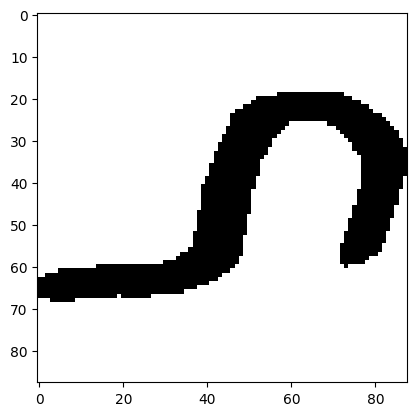

In [206]:
plt.imshow(chars_cropped[2]);

In [155]:
for i in range(num_chars):
    print(char_cropped[i].shape);

(61,)
(61,)
(61,)
(61,)


In [216]:
suggested_words = get_word_suggestions(predicted_letters_str)

if len(suggested_words) == 0:
    print("No matching words found.")
else:
    print("Suggested words:")
    for i, word in enumerate(suggested_words):
        print(f"{i + 1}. {word}")
    choice = input("Choose a word from the list (enter the number): ")
    chosen_word = suggested_words[int(choice) - 1]
    print(f"You chose: {chosen_word}")

100%|███████████████████████████████████████████████████████████████████████| 469509/469509 [00:19<00:00, 23766.59it/s]


Suggested words:
1. אכתב
2. הכתב
3. יכתב
4. כתב
5. מוכתב
6. מכותב
7. מכזב
8. מככב
9. מכת
10. מכתב
11. מכתבה
12. מכתבו
13. מכתבי
14. מכתבך
15. מכתבם
16. מכתבן
17. מכתבת
18. מכתיב
19. מכתם
20. מכתר
21. מכתש
22. מכתת
23. מנתב
24. משכתב
25. מתכתב
26. נכתב
27. שכתב
28. תכתב
29. מכתה
30. מכתו
31. מכתך
32. מכתן


Choose a word from the list (enter the number):  10


You chose: מכתב
